# Deep Mean Shift Clustering

## Reqs

### Download

In [38]:
# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# !pip install pillow==4.1.1
# %reload_ext autoreload
# %autoreload
# !pip install python-mnist
# # !/usr/local/bin/python -m pip install visdom
# # !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip


### Import

In [39]:
import mnist
import visdom
vis = visdom.Visdom(port='8097')
import pickle
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable, Function, gradcheck

## Dataset

### Download

In [40]:
# trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor()])
root = '~/btp_mean_shift/content'
train = torchvision.datasets.MNIST(root, train=True, transform=trans, target_transform=None, download=True)
test = torchvision.datasets.MNIST(root, train=False, transform=trans, target_transform=None, download=True)

### Load

In [41]:
train_batch_size = 512
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=train_batch_size,
                 shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=test_batch_size,
                shuffle=False)

print ('total trainning batch number: '+ str(len(train_loader)))
print ('total testing batch number: '+ str(len(test_loader)))fd

total trainning batch number: 118
total testing batch number: 100


## Plotter

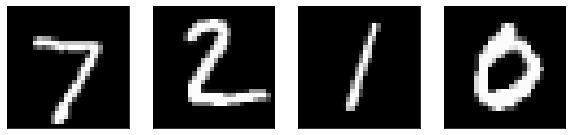

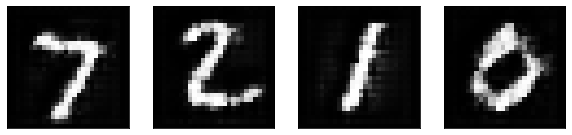

In [53]:
def plot_regen(model):

    for batch_idx, (x, target) in enumerate(test_loader):

        train_image = x
        break

    fig=plt.figure(figsize=(10,40))

    num_im = 4
    for i in range(num_im):
        data = np.array(train_image[i], dtype='float')
        data = data.reshape((28, 28))
        ax = fig.add_subplot(1, num_im, i+1)
        plt.imshow(data, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

    fig=plt.figure(figsize=(10,40))

    data = train_image.float()
    out, embed = model(data.cuda())
    out = out.cpu().detach().numpy()

    num_im = 4
    for i in range(num_im):
        out1 = out[i].reshape((28, 28))
        out1 = np.array(out1, dtype='float')
        
        ax = fig.add_subplot(1, num_im, i+1)
        plt.imshow(out1, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

# plot_regen(model)

# AE Def

## Backbone + Regen

In [43]:
class AE(nn.Module):
    def __init__(self, z_len):
        super(AE, self).__init__()

        self.conv_1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.ind1 = 0
        self.ind2 = 0
        self.conv_2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(4*4*50, 500)
        self.fc_2 = nn.Linear(500,z_len)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.upfc_1 = nn.Linear(z_len, 500)
        self.upfc_2 = nn.Linear(500, 4*4*50)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.upconv_1 = nn.ConvTranspose2d(50, 20, kernel_size=5, stride=1)
        self.upconv_2 = nn.ConvTranspose2d(20, 1, kernel_size=5, stride=1)  

    def encode(self, x):
        z = self.conv_1(x)
        z = self.relu(z)
        z, self.ind1 = self.pool(z)
        z = self.conv_2(z)
        z = self.relu(z)
        z, self.ind2 = self.pool(z)
        z = z.view(z.size(0), -1)
        z = self.fc_1(z)
        z = self.relu(z)
        z = self.fc_2(z)
        z_norm = z.norm(p=2, dim=1, keepdim=True).detach()
        z = z.div(z_norm.expand_as(z))
        return z

#     def mean_shift_cluster(self, X, delta, eta):
#         S = torch.mm(X.t(), X)
#         K = torch.exp(delta * S)
#         N = list(X.size())[1]
#         d = torch.mm(K.t(), torch.ones(N, 1).cuda())
#         q = 1 / d
#         D_inv = torch.diagflat(q)
#         eye = torch.eye(N).cuda()
#         P = ((1-eta) * eye) + (eta * torch.mm(K, D_inv))
#         return torch.mm(X, P)

    def decode(self, z):
        x = self.upfc_1(z)
        x = self.relu(x)
        x = self.upfc_2(x)
        x = x.view(x.size(0), 50, 4, 4)
        x = self.unpool(x, self.ind2)
        x = self.relu(x)
        x = self.upconv_1(x)
        x = self.unpool(x, self.ind1)
        x = self.relu(x)
        x = self.upconv_2(x)
        x = self.sigmoid(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_ = self.decode(z)
        return x_, z

## Mean Shift Cluster

In [44]:
class Mean_Shift_Cluster(torch.nn.Module):

    def __init__(self, delta, eta, ms_iter):
        super(Mean_Shift_Cluster, self).__init__()
        self.delta = delta
        self.eta = eta
        self.ms_iter = ms_iter

    def mean_shift_once(self, X):
        S = torch.mm(X.t(), X)
        K = torch.exp(self.delta * S)
        N = list(X.size())[1]
        d = torch.mm(K.t(), torch.ones(N, 1).cuda())
        q = 1 / d
        D_inv = torch.diagflat(q)
        eye = torch.eye(N).cuda()
        P = ((1-self.eta) * eye) + (self.eta * torch.mm(K, D_inv))
        return torch.mm(X, P)
  
    def forward(self, X):
        # dims: seq_len x embedding_dim_1 x batch_size
        
        clust_embs = self.mean_shift_once(X).unsqueeze(0)
        for it in range(1, self.ms_iter):
            clust_embs = torch.cat((clust_embs, self.mean_shift_once(clust_embs[it-1]).unsqueeze(0)))
        
        # dims: batch_size x seq_len x embedding_dim_1
        clust_embs = clust_embs.permute(2, 0, 1)
        
        return clust_embs

## Trajectory LSTM

In [45]:
class Path_LSTM(nn.Module):

    def __init__(self, embed_1, embed_2, num_layers=1):
        super(Path_LSTM , self).__init__() 
        
        self.embed_1 = embed_1
        self.embed_2 = embed_2
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.embed_1 , self.embed_2, batch_first=True, num_layers=self.num_layers).cuda()

    def forward(self , x):
        
        batch_size = x.size()[0]
        h0 = torch.randn(self.num_layers, batch_size, self.embed_2).cuda()
        c0 = torch.randn(self.num_layers, batch_size, self.embed_2).cuda()

        state = (h0, c0) 
        self.lstm.flatten_parameters()
        out, (h_n,c_n) = self.lstm(x, state) 
        sq_h_n = torch.squeeze(h_n)
        return sq_h_n

## Loss

In [46]:
class Loss(torch.nn.Module):

    def __init__(self, alpha):
        super(Loss, self).__init__()
        self.alpha = alpha
        self.mse = torch.nn.MSELoss(reduction='elementwise_mean')
        
    def cluster_loss(self, embeddings, y):
        total =  len(y)
        loss_list = torch.zeros(total, total).cuda()
        for i in range(total):
            for j in range(i+1, total):
                if y[i] == y[j]:
                    x = embeddings[i]
                    x_ = embeddings[j]
                    loss_list[i, j] = self.mse(x, x_)
        
        return loss_list.sum() 
  
    def regen_loss(self, X, X_):
        regen_loss = torch.sum(torch.mm((X-X_).view(1, -1), (X-X_).view(-1, 1)))/X.view(-1).size()[0]
        return regen_loss
    
    def forward(self, X, X_, embeddings, y):
        ms_loss = self.cluster_loss(embeddings, y)    
        ae_loss = self.regen_loss(X, X_)
        return ms_loss + ae_loss, ms_loss, ae_loss

## Weights

In [47]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)


# Model Init

## Params

In [48]:
alpha = 0.5 
eta = 1 
ms_iter = 10
delta = 3 / (1-alpha)
total_epochs = 150
embedding_dim_1 = 64
embedding_dim_2 = 14
num_layers=1

## Init

In [51]:
sname = 'pre_regen_shift_lstm'

# Load pre-trained auto encoder
model = AE(embedding_dim_1)
model.load_state_dict(torch.load('/home/ankitas/btp_mean_shift/save/'+sname+'.pt'))
model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.SGD(model.parameters())
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

ms_clust = Mean_Shift_Cluster(delta, eta, ms_iter)
path_embed = Path_LSTM(embedding_dim_1, embedding_dim_2, num_layers)
ms_ae_loss = Loss(alpha)
# new_loss = torch.nn.BCELoss(reduce=False)

# Train

epoch 0
epoch 0 batch 0 batch total loss 3.4645295
epoch 0 batch 0 batch cluster loss 3.4571488
epoch 0 batch 0 batch regen loss 0.007380718
saving...



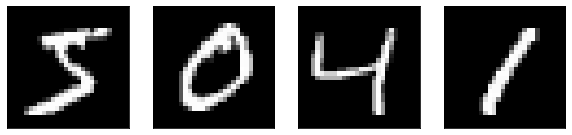

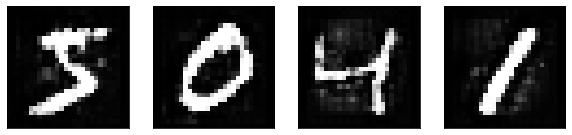

epoch 0 batch 50 batch total loss 0.15392265
epoch 0 batch 50 batch cluster loss 0.14219515
epoch 0 batch 50 batch regen loss 0.011727498
saving...



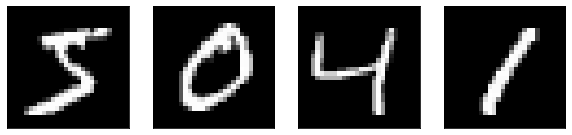

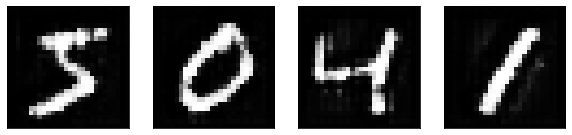

epoch 0 batch 100 batch total loss 0.14478588
epoch 0 batch 100 batch cluster loss 0.13161516
epoch 0 batch 100 batch regen loss 0.013170717
saving...



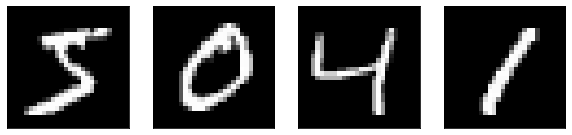

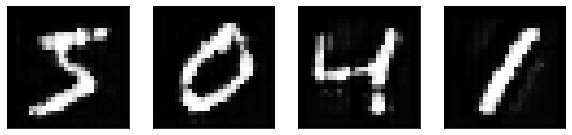


epoch 0 epoch avg loss 0.218918177977962
epoch 0 epoch avg cluster loss 0.20722532534371998
epoch 0 epoch avg regen loss 0.011692852709221385



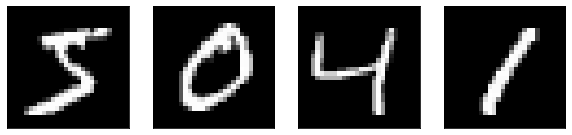

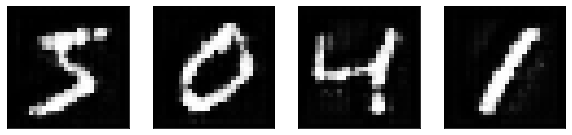

saving...

epoch 1
epoch 1 batch 0 batch total loss 0.13855626
epoch 1 batch 0 batch cluster loss 0.1264854
epoch 1 batch 0 batch regen loss 0.012070852
saving...



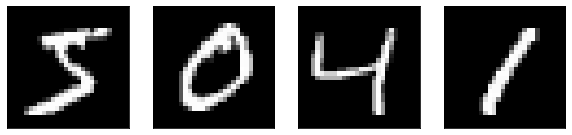

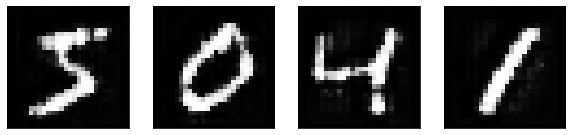

epoch 1 batch 50 batch total loss 0.1333025
epoch 1 batch 50 batch cluster loss 0.11939905
epoch 1 batch 50 batch regen loss 0.013903451
saving...



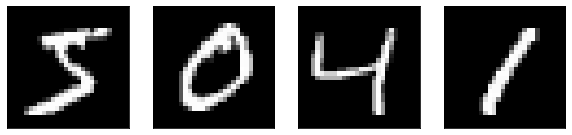

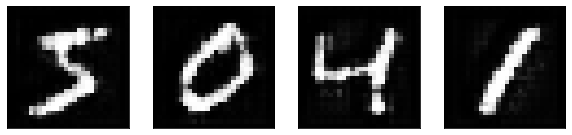

epoch 1 batch 100 batch total loss 0.1312965
epoch 1 batch 100 batch cluster loss 0.11696618
epoch 1 batch 100 batch regen loss 0.014330316
saving...



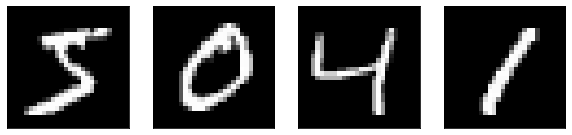

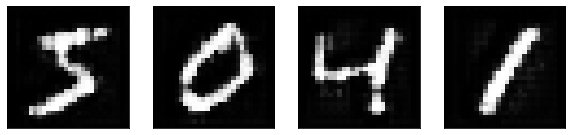


epoch 1 epoch avg loss 0.1366007166709435
epoch 1 epoch avg cluster loss 0.12278567547357436
epoch 1 epoch avg regen loss 0.013815040723815307



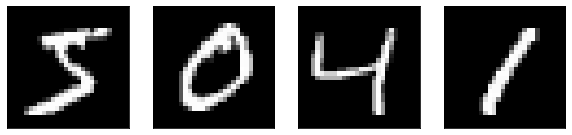

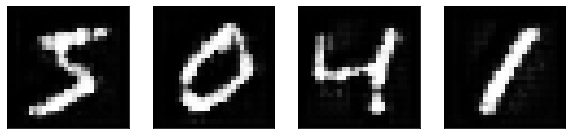

saving...

epoch 2
epoch 2 batch 0 batch total loss 0.12555026
epoch 2 batch 0 batch cluster loss 0.11251192
epoch 2 batch 0 batch regen loss 0.013038342
saving...



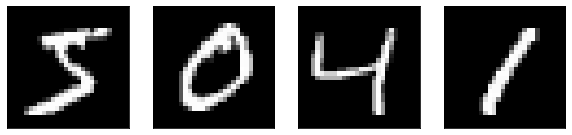

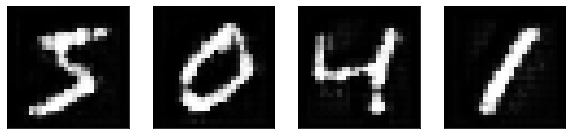

epoch 2 batch 50 batch total loss 0.1399278
epoch 2 batch 50 batch cluster loss 0.12504852
epoch 2 batch 50 batch regen loss 0.014879283
saving...



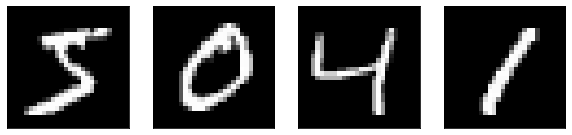

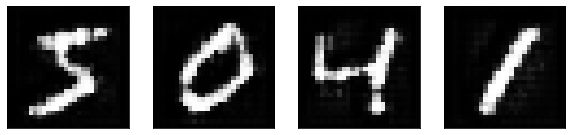

epoch 2 batch 100 batch total loss 0.13482623
epoch 2 batch 100 batch cluster loss 0.11967841
epoch 2 batch 100 batch regen loss 0.015147821
saving...



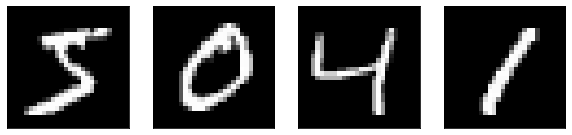

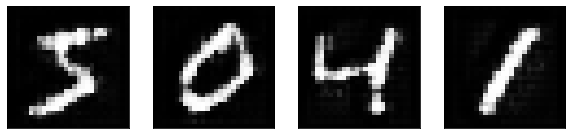


epoch 2 epoch avg loss 0.13261510737998
epoch 2 epoch avg cluster loss 0.1179408857922496
epoch 2 epoch avg regen loss 0.01467422146539567



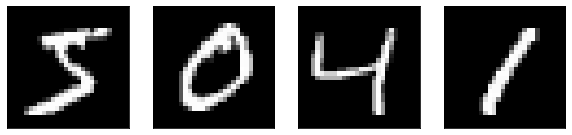

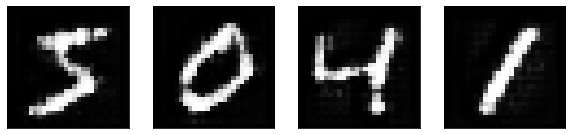

saving...

epoch 3
epoch 3 batch 0 batch total loss 0.13441566
epoch 3 batch 0 batch cluster loss 0.1206565
epoch 3 batch 0 batch regen loss 0.01375916
saving...



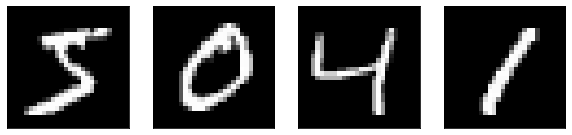

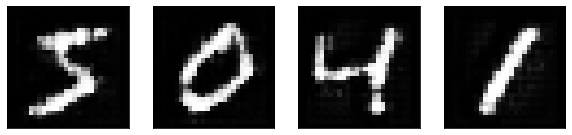

epoch 3 batch 50 batch total loss 0.14626698
epoch 3 batch 50 batch cluster loss 0.13076326
epoch 3 batch 50 batch regen loss 0.015503725
saving...



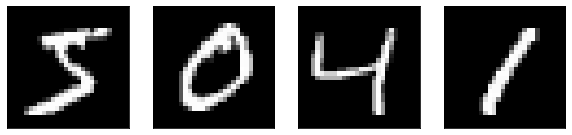

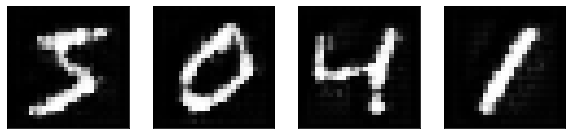

epoch 3 batch 100 batch total loss 0.1352589
epoch 3 batch 100 batch cluster loss 0.11970373
epoch 3 batch 100 batch regen loss 0.015555165
saving...



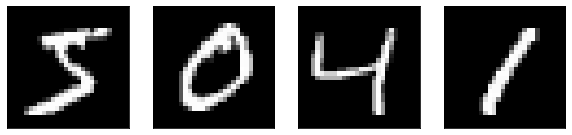

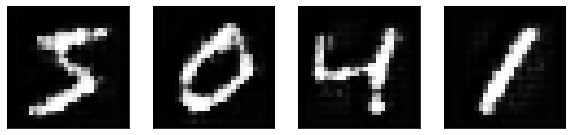


epoch 3 epoch avg loss 0.1305498069278517
epoch 3 epoch avg cluster loss 0.1153266780469093
epoch 3 epoch avg regen loss 0.015223129036820542



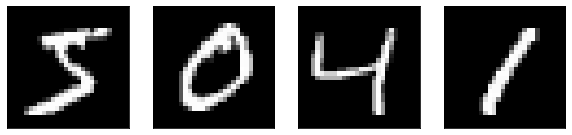

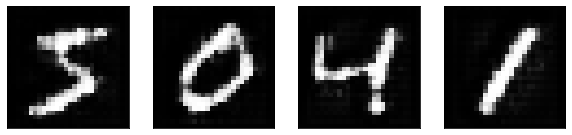

saving...

epoch 4
epoch 4 batch 0 batch total loss 0.12792885
epoch 4 batch 0 batch cluster loss 0.113802165
epoch 4 batch 0 batch regen loss 0.01412669
saving...



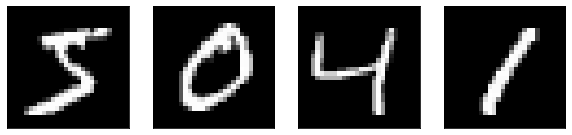

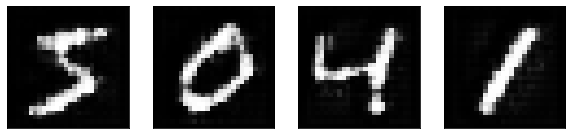

epoch 4 batch 50 batch total loss 0.12927867
epoch 4 batch 50 batch cluster loss 0.11348195
epoch 4 batch 50 batch regen loss 0.015796727
saving...



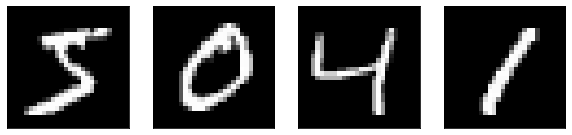

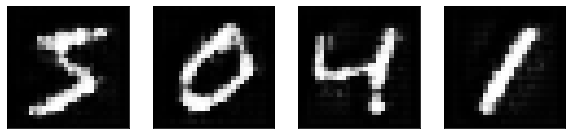

epoch 4 batch 100 batch total loss 0.12718068
epoch 4 batch 100 batch cluster loss 0.111411326
epoch 4 batch 100 batch regen loss 0.01576935
saving...



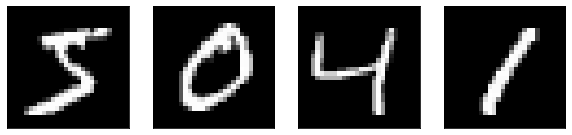

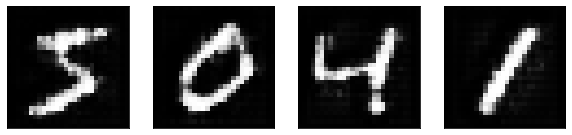


epoch 4 epoch avg loss 0.12930248317829632
epoch 4 epoch avg cluster loss 0.11379770699383343
epoch 4 epoch avg regen loss 0.015504776042396739



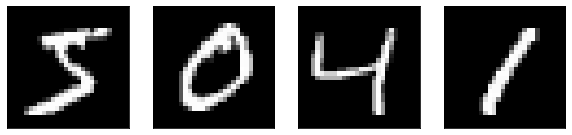

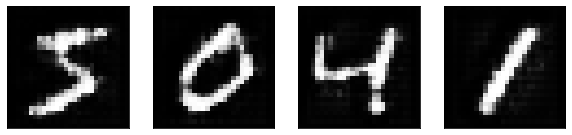

saving...

epoch 5
epoch 5 batch 0 batch total loss 0.12493355
epoch 5 batch 0 batch cluster loss 0.11064265
epoch 5 batch 0 batch regen loss 0.014290901
saving...



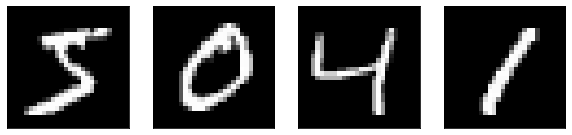

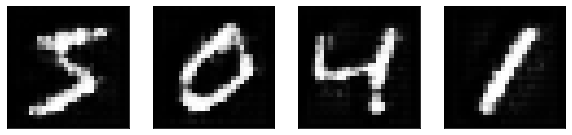

epoch 5 batch 50 batch total loss 0.12706703
epoch 5 batch 50 batch cluster loss 0.111142874
epoch 5 batch 50 batch regen loss 0.01592416
saving...



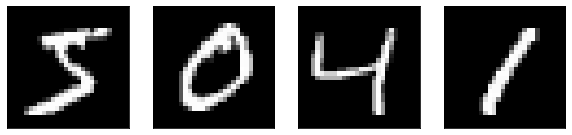

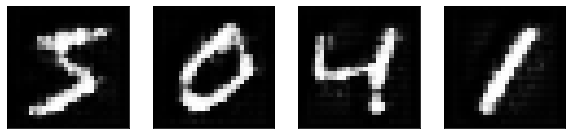

epoch 5 batch 100 batch total loss 0.13362534
epoch 5 batch 100 batch cluster loss 0.11776692
epoch 5 batch 100 batch regen loss 0.01585843
saving...



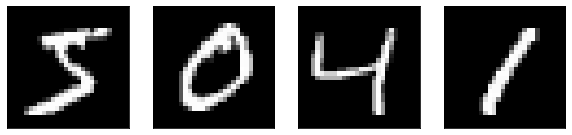

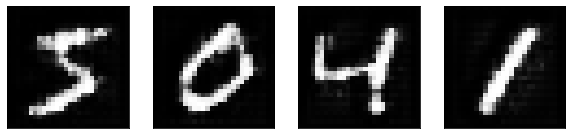


epoch 5 epoch avg loss 0.12887117588671587
epoch 5 epoch avg cluster loss 0.11325346622655516
epoch 5 epoch avg regen loss 0.0156177098515554



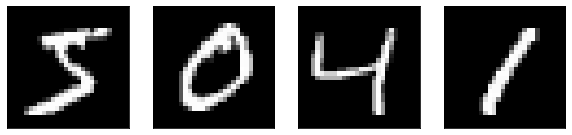

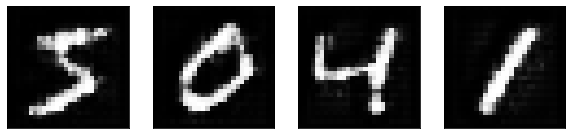

saving...

epoch 6
epoch 6 batch 0 batch total loss 0.1312331
epoch 6 batch 0 batch cluster loss 0.11685453
epoch 6 batch 0 batch regen loss 0.014378562
saving...



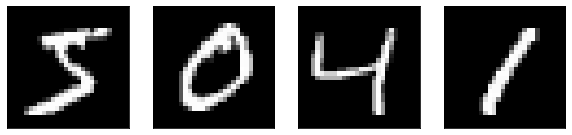

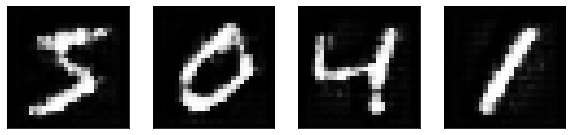

epoch 6 batch 50 batch total loss 0.13613158
epoch 6 batch 50 batch cluster loss 0.120102376
epoch 6 batch 50 batch regen loss 0.016029207
saving...



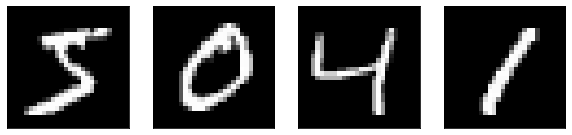

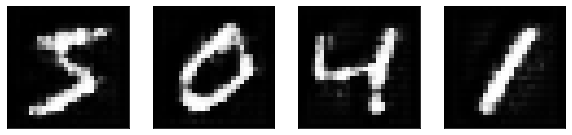

epoch 6 batch 100 batch total loss 0.1241155
epoch 6 batch 100 batch cluster loss 0.10817015
epoch 6 batch 100 batch regen loss 0.015945341
saving...



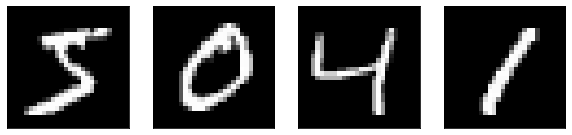

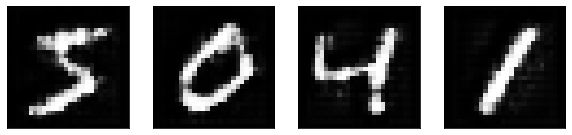


epoch 6 epoch avg loss 0.1289033672567141
epoch 6 epoch avg cluster loss 0.11319745637839503
epoch 6 epoch avg regen loss 0.015705910519207434



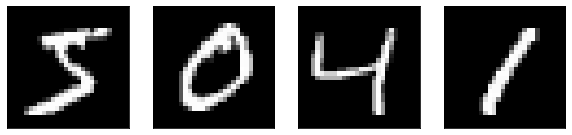

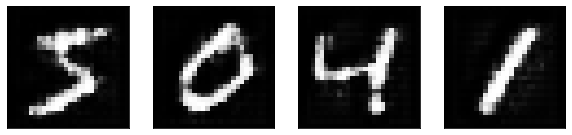

saving...

epoch 7
epoch 7 batch 0 batch total loss 0.1295267
epoch 7 batch 0 batch cluster loss 0.11508776
epoch 7 batch 0 batch regen loss 0.014438948
saving...



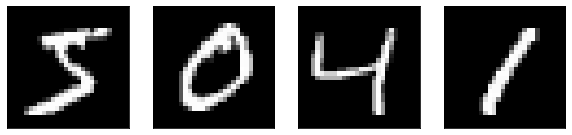

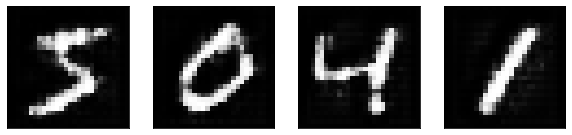

epoch 7 batch 50 batch total loss 0.13321313
epoch 7 batch 50 batch cluster loss 0.11710486
epoch 7 batch 50 batch regen loss 0.01610827
saving...



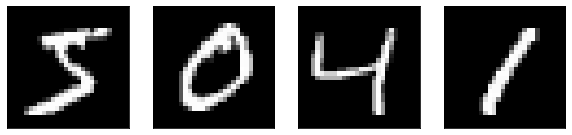

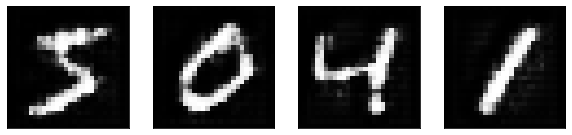

epoch 7 batch 100 batch total loss 0.1267042
epoch 7 batch 100 batch cluster loss 0.11068275
epoch 7 batch 100 batch regen loss 0.01602145
saving...



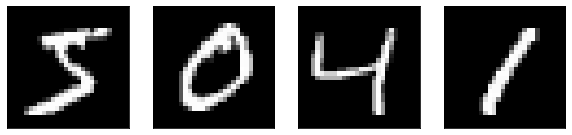

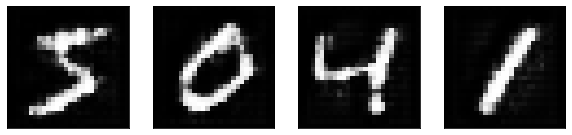


epoch 7 epoch avg loss 0.12848138916542975
epoch 7 epoch avg cluster loss 0.11271416915233358
epoch 7 epoch avg regen loss 0.015767219547434885



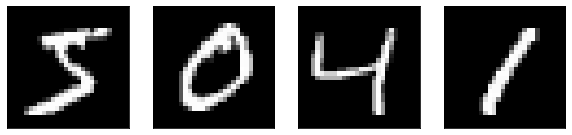

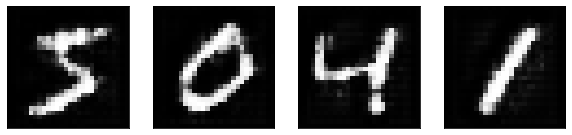

saving...

epoch 8
epoch 8 batch 0 batch total loss 0.12529445
epoch 8 batch 0 batch cluster loss 0.11082089
epoch 8 batch 0 batch regen loss 0.0144735575
saving...



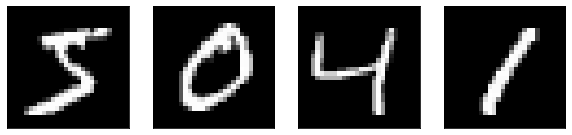

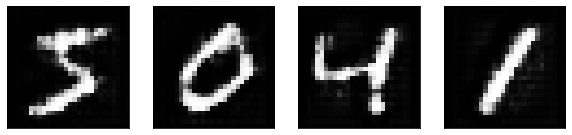

epoch 8 batch 50 batch total loss 0.12679566
epoch 8 batch 50 batch cluster loss 0.11064438
epoch 8 batch 50 batch regen loss 0.016151289
saving...



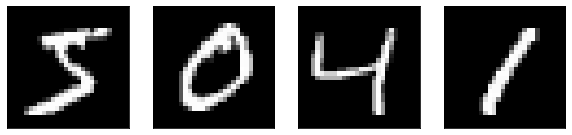

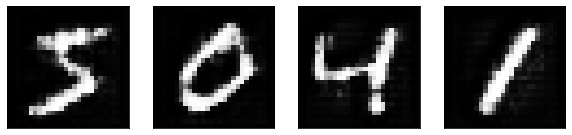

epoch 8 batch 100 batch total loss 0.13327345
epoch 8 batch 100 batch cluster loss 0.11716961
epoch 8 batch 100 batch regen loss 0.01610384
saving...



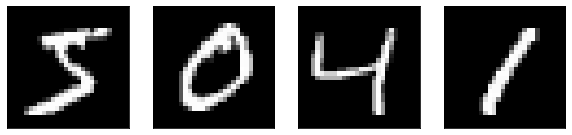

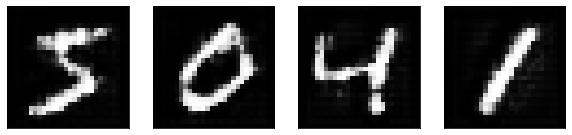


epoch 8 epoch avg loss 0.1273858437977605
epoch 8 epoch avg cluster loss 0.11157016561690213
epoch 8 epoch avg regen loss 0.01581567826570343



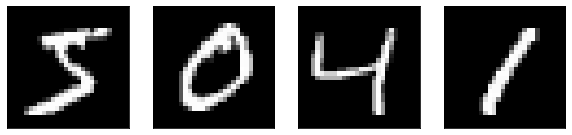

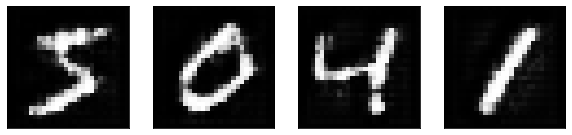

saving...

epoch 9
epoch 9 batch 0 batch total loss 0.12319772
epoch 9 batch 0 batch cluster loss 0.10864267
epoch 9 batch 0 batch regen loss 0.01455505
saving...



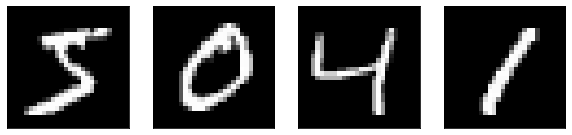

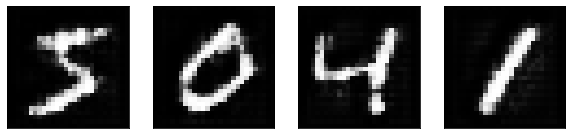

epoch 9 batch 50 batch total loss 0.13074657
epoch 9 batch 50 batch cluster loss 0.114530906
epoch 9 batch 50 batch regen loss 0.016215669
saving...



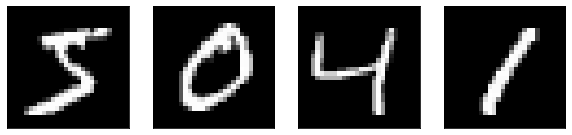

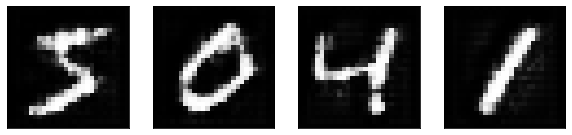

epoch 9 batch 100 batch total loss 0.123497725
epoch 9 batch 100 batch cluster loss 0.10736197
epoch 9 batch 100 batch regen loss 0.01613575
saving...



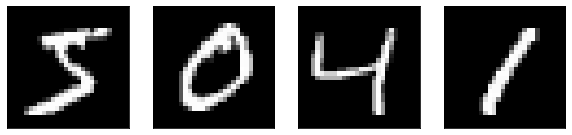

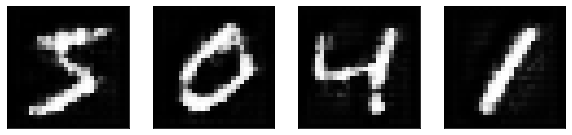


epoch 9 epoch avg loss 0.12753887053073967
epoch 9 epoch avg cluster loss 0.11168293357763628
epoch 9 epoch avg regen loss 0.015855937320107625



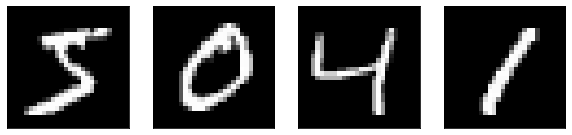

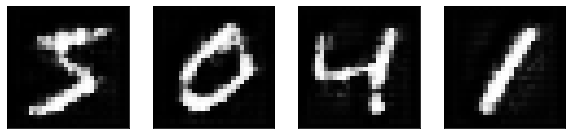

saving...

epoch 10
epoch 10 batch 0 batch total loss 0.1254168
epoch 10 batch 0 batch cluster loss 0.11080972
epoch 10 batch 0 batch regen loss 0.014607084
saving...



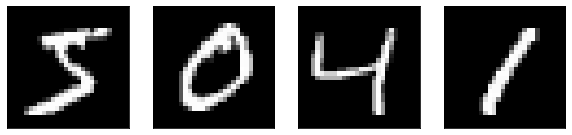

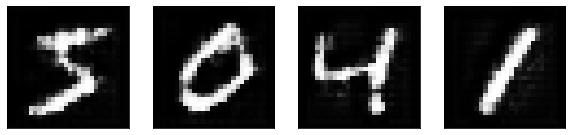

epoch 10 batch 50 batch total loss 0.12534194
epoch 10 batch 50 batch cluster loss 0.1090723
epoch 10 batch 50 batch regen loss 0.016269634
saving...



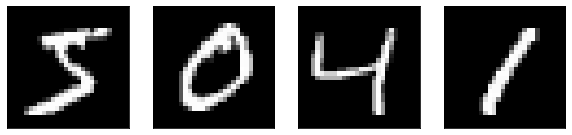

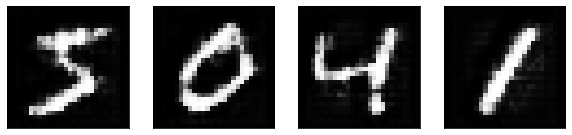

epoch 10 batch 100 batch total loss 0.1201728
epoch 10 batch 100 batch cluster loss 0.10400198
epoch 10 batch 100 batch regen loss 0.016170822
saving...



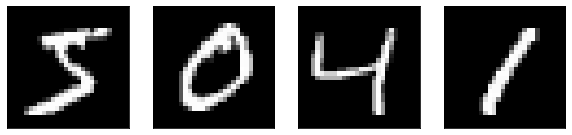

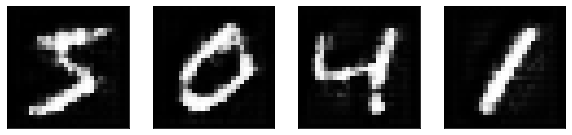


epoch 10 epoch avg loss 0.12631934892259916
epoch 10 epoch avg cluster loss 0.11042698146183423
epoch 10 epoch avg regen loss 0.015892366910258592



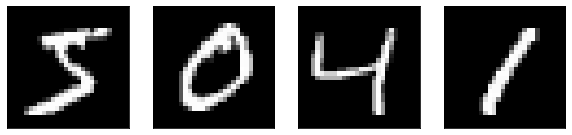

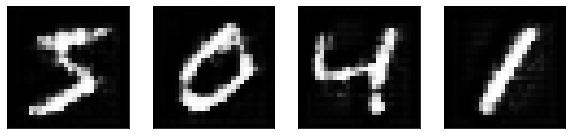

saving...

epoch 11
epoch 11 batch 0 batch total loss 0.12982187
epoch 11 batch 0 batch cluster loss 0.115180455
epoch 11 batch 0 batch regen loss 0.014641413
saving...



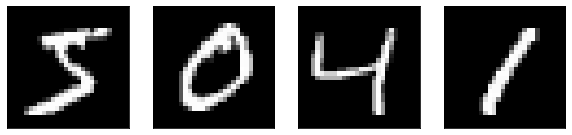

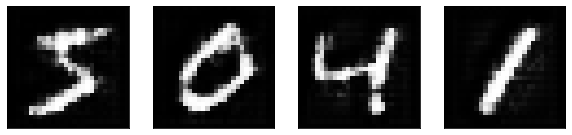

epoch 11 batch 50 batch total loss 0.1318591
epoch 11 batch 50 batch cluster loss 0.1155589
epoch 11 batch 50 batch regen loss 0.016300201
saving...



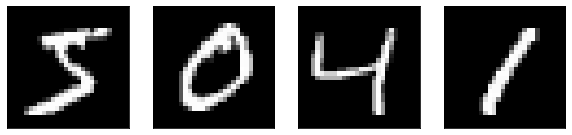

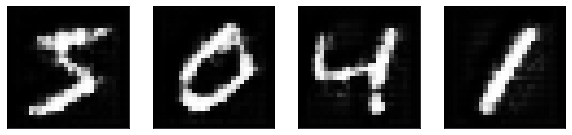

epoch 11 batch 100 batch total loss 0.12741885
epoch 11 batch 100 batch cluster loss 0.11120437
epoch 11 batch 100 batch regen loss 0.01621447
saving...



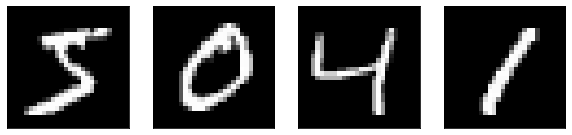

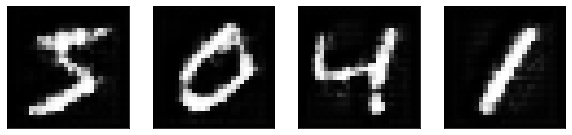


epoch 11 epoch avg loss 0.12703596923689722
epoch 11 epoch avg cluster loss 0.11110786663297312
epoch 11 epoch avg regen loss 0.01592810255459557



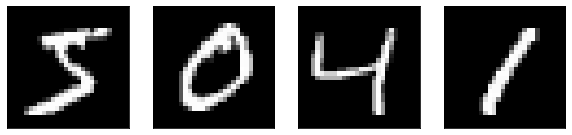

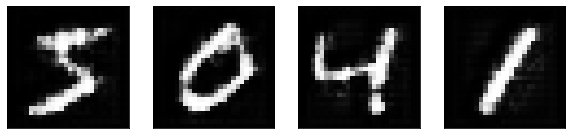

saving...

epoch 12
epoch 12 batch 0 batch total loss 0.12444318
epoch 12 batch 0 batch cluster loss 0.109758385
epoch 12 batch 0 batch regen loss 0.014684798
saving...



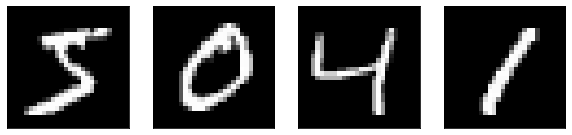

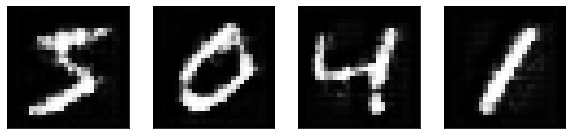

epoch 12 batch 50 batch total loss 0.12284382
epoch 12 batch 50 batch cluster loss 0.10648146
epoch 12 batch 50 batch regen loss 0.016362352
saving...



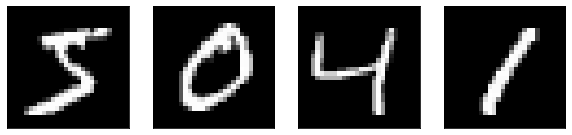

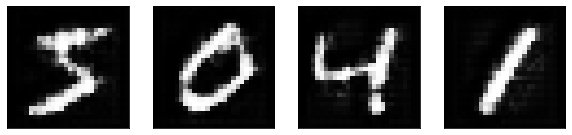

epoch 12 batch 100 batch total loss 0.12301686
epoch 12 batch 100 batch cluster loss 0.10676174
epoch 12 batch 100 batch regen loss 0.016255118
saving...



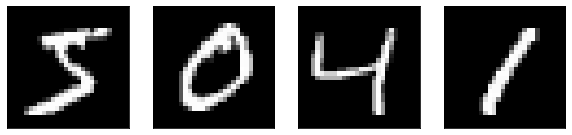

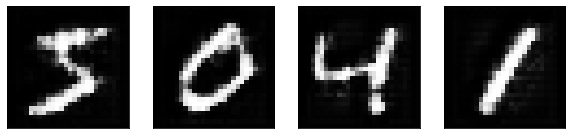


epoch 12 epoch avg loss 0.1266833190664144
epoch 12 epoch avg cluster loss 0.1107243468740292
epoch 12 epoch avg regen loss 0.01595897200690993



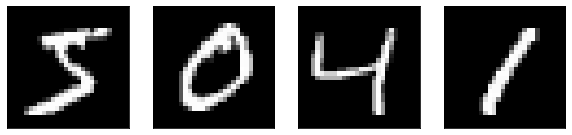

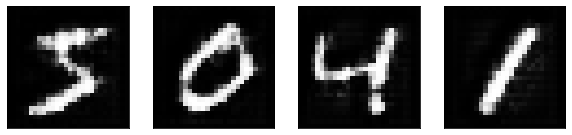

saving...

epoch 13
epoch 13 batch 0 batch total loss 0.12758891
epoch 13 batch 0 batch cluster loss 0.11287043
epoch 13 batch 0 batch regen loss 0.014718483
saving...



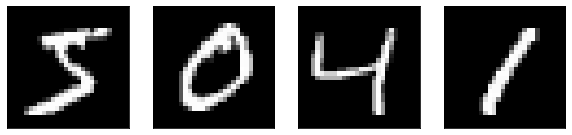

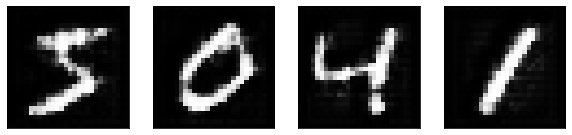

epoch 13 batch 50 batch total loss 0.12825768
epoch 13 batch 50 batch cluster loss 0.111861885
epoch 13 batch 50 batch regen loss 0.01639579
saving...



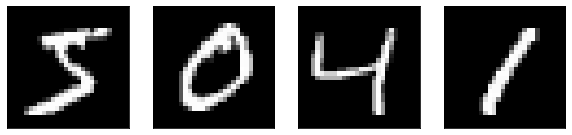

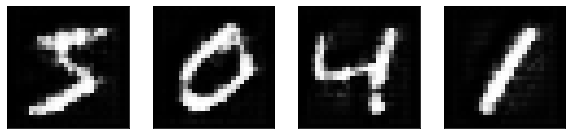

epoch 13 batch 100 batch total loss 0.13279879
epoch 13 batch 100 batch cluster loss 0.116505526
epoch 13 batch 100 batch regen loss 0.016293267
saving...



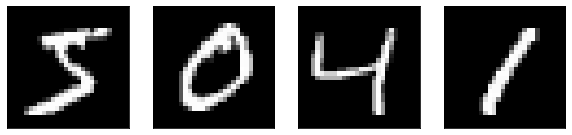

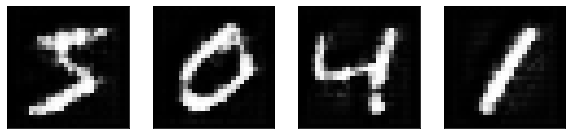


epoch 13 epoch avg loss 0.12709480352005212
epoch 13 epoch avg cluster loss 0.11111021260494146
epoch 13 epoch avg regen loss 0.01598459062308578



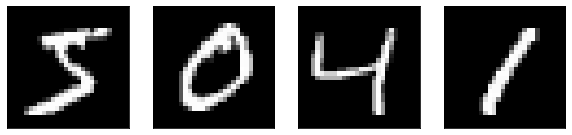

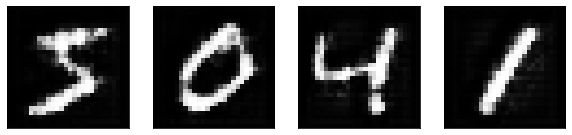

saving...

epoch 14
epoch 14 batch 0 batch total loss 0.12219681
epoch 14 batch 0 batch cluster loss 0.10745936
epoch 14 batch 0 batch regen loss 0.014737449
saving...



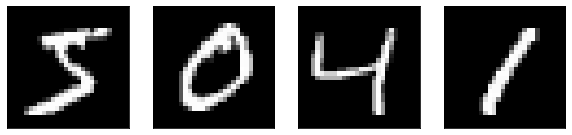

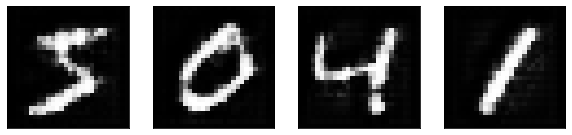

epoch 14 batch 50 batch total loss 0.12416248
epoch 14 batch 50 batch cluster loss 0.10776475
epoch 14 batch 50 batch regen loss 0.016397731
saving...



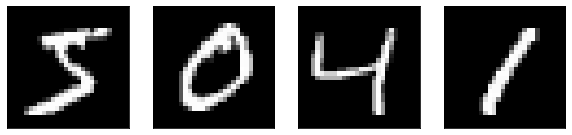

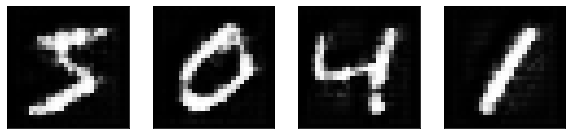

epoch 14 batch 100 batch total loss 0.12765335
epoch 14 batch 100 batch cluster loss 0.111340165
epoch 14 batch 100 batch regen loss 0.016313175
saving...



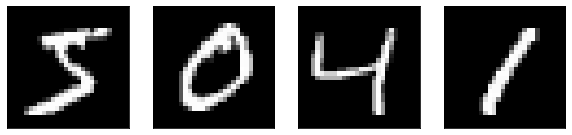

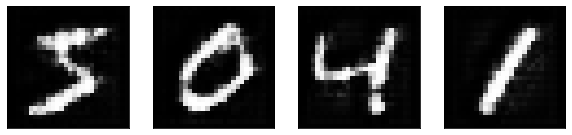


epoch 14 epoch avg loss 0.12738703102883647
epoch 14 epoch avg cluster loss 0.11138046227032476
epoch 14 epoch avg regen loss 0.01600656895187952



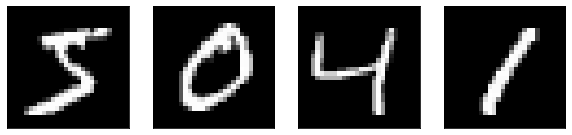

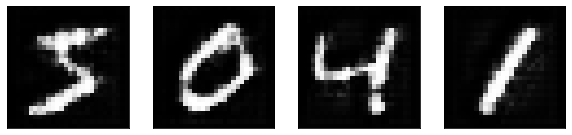

saving...

epoch 15
epoch 15 batch 0 batch total loss 0.12505364
epoch 15 batch 0 batch cluster loss 0.11029781
epoch 15 batch 0 batch regen loss 0.014755841
saving...



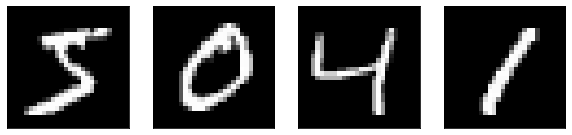

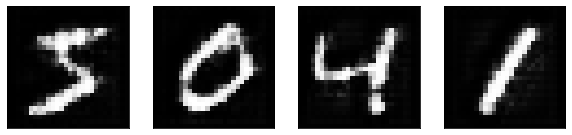

epoch 15 batch 50 batch total loss 0.1323873
epoch 15 batch 50 batch cluster loss 0.1159728
epoch 15 batch 50 batch regen loss 0.016414493
saving...



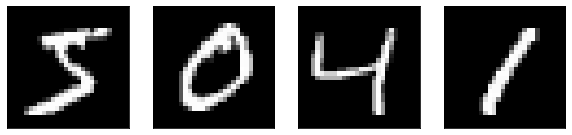

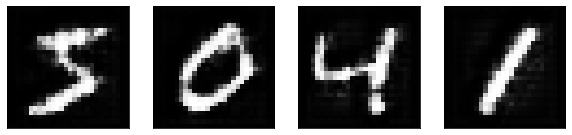

epoch 15 batch 100 batch total loss 0.12517983
epoch 15 batch 100 batch cluster loss 0.10884652
epoch 15 batch 100 batch regen loss 0.01633331
saving...



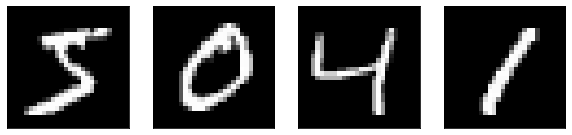

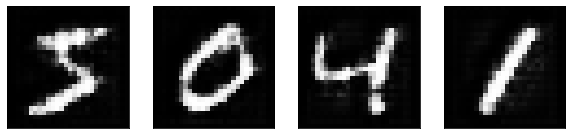


epoch 15 epoch avg loss 0.12676849203594662
epoch 15 epoch avg cluster loss 0.11073570427784728
epoch 15 epoch avg regen loss 0.016032787773884453



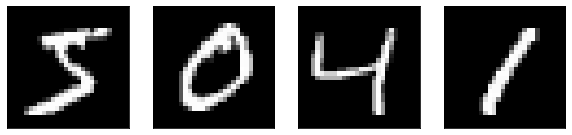

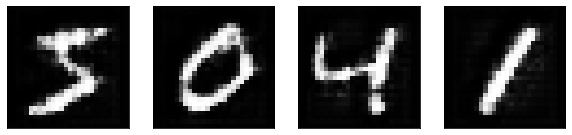

saving...

epoch 16
epoch 16 batch 0 batch total loss 0.13116539
epoch 16 batch 0 batch cluster loss 0.116398245
epoch 16 batch 0 batch regen loss 0.014767139
saving...



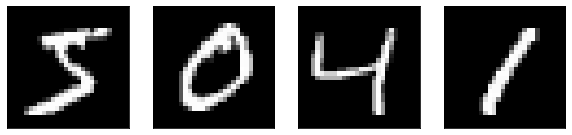

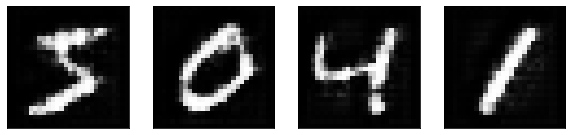

epoch 16 batch 50 batch total loss 0.12782772
epoch 16 batch 50 batch cluster loss 0.11139187
epoch 16 batch 50 batch regen loss 0.016435841
saving...



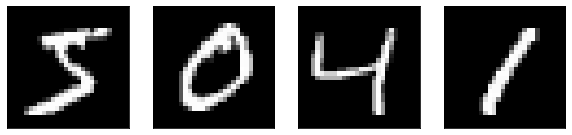

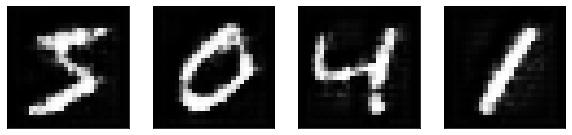

epoch 16 batch 100 batch total loss 0.12584908
epoch 16 batch 100 batch cluster loss 0.10948502
epoch 16 batch 100 batch regen loss 0.016364064
saving...



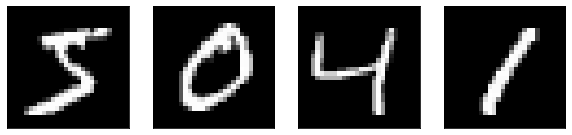

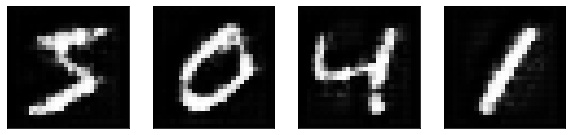


epoch 16 epoch avg loss 0.12696965936950202
epoch 16 epoch avg cluster loss 0.11092153248787558
epoch 16 epoch avg regen loss 0.016048126775076835



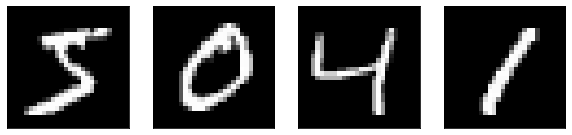

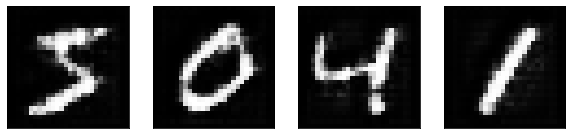

saving...

epoch 17
epoch 17 batch 0 batch total loss 0.13225931
epoch 17 batch 0 batch cluster loss 0.11747537
epoch 17 batch 0 batch regen loss 0.014783948
saving...



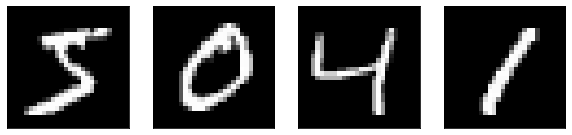

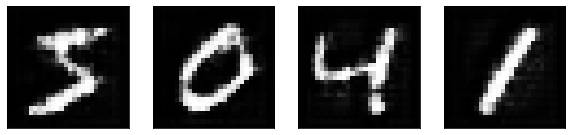

epoch 17 batch 50 batch total loss 0.12845102
epoch 17 batch 50 batch cluster loss 0.112027675
epoch 17 batch 50 batch regen loss 0.016423346
saving...



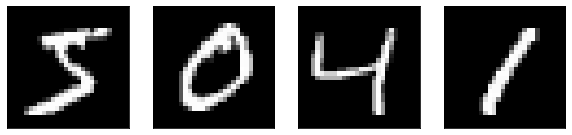

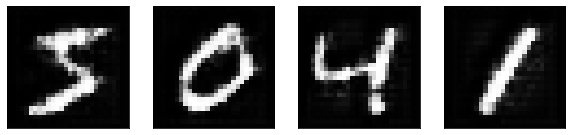

epoch 17 batch 100 batch total loss 0.12488074
epoch 17 batch 100 batch cluster loss 0.10853657
epoch 17 batch 100 batch regen loss 0.01634417
saving...



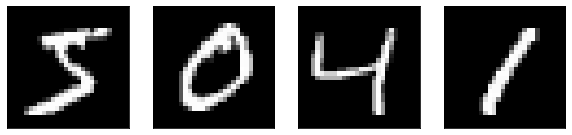

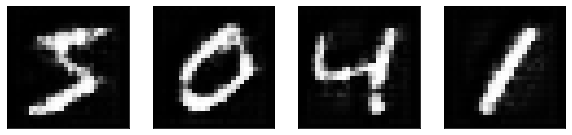


epoch 17 epoch avg loss 0.12648296992341845
epoch 17 epoch avg cluster loss 0.11043361744693464
epoch 17 epoch avg regen loss 0.016049352506080927



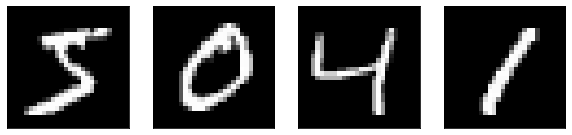

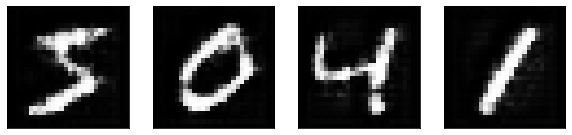

saving...

epoch 18
epoch 18 batch 0 batch total loss 0.13092448
epoch 18 batch 0 batch cluster loss 0.11614427
epoch 18 batch 0 batch regen loss 0.014780208
saving...



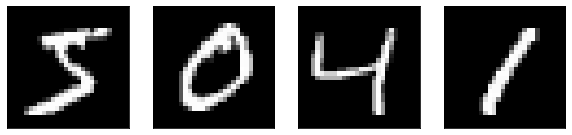

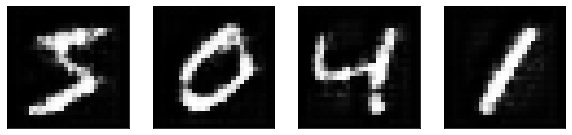

epoch 18 batch 50 batch total loss 0.12466969
epoch 18 batch 50 batch cluster loss 0.10827207
epoch 18 batch 50 batch regen loss 0.016397625
saving...



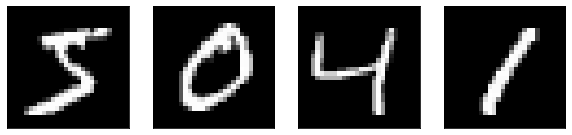

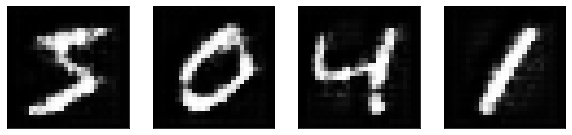

epoch 18 batch 100 batch total loss 0.12978578
epoch 18 batch 100 batch cluster loss 0.11344162
epoch 18 batch 100 batch regen loss 0.016344167
saving...



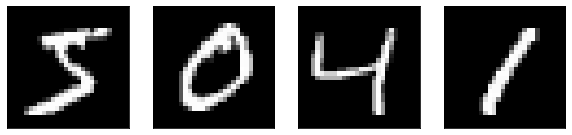

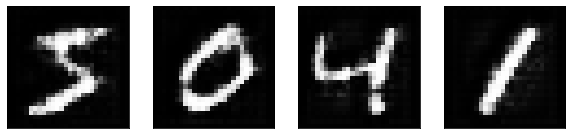


epoch 18 epoch avg loss 0.12651651494710123
epoch 18 epoch avg cluster loss 0.11047271995852559
epoch 18 epoch avg regen loss 0.016043794949112806



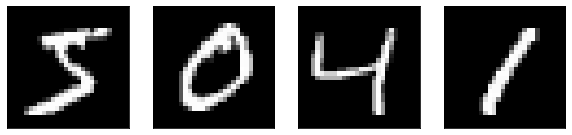

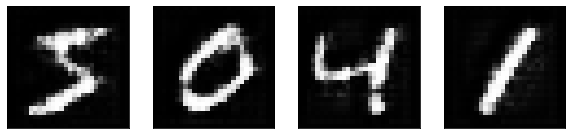

saving...

epoch 19
epoch 19 batch 0 batch total loss 0.1266458
epoch 19 batch 0 batch cluster loss 0.111871004
epoch 19 batch 0 batch regen loss 0.014774807
saving...



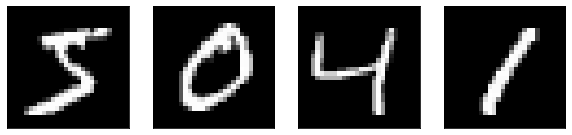

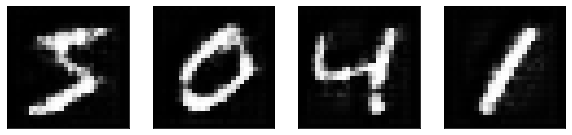

epoch 19 batch 50 batch total loss 0.12630686
epoch 19 batch 50 batch cluster loss 0.10992285
epoch 19 batch 50 batch regen loss 0.016384006
saving...



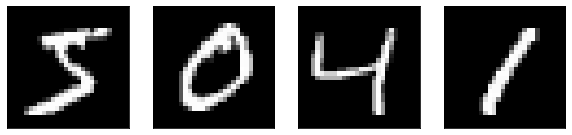

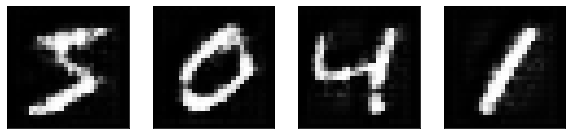

epoch 19 batch 100 batch total loss 0.13141121
epoch 19 batch 100 batch cluster loss 0.11508194
epoch 19 batch 100 batch regen loss 0.016329268
saving...



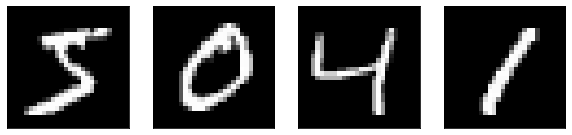

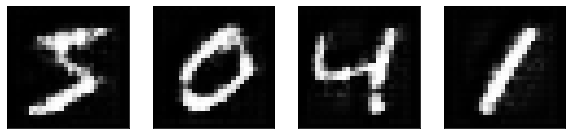


epoch 19 epoch avg loss 0.1262774356972363
epoch 19 epoch avg cluster loss 0.11024486628692534
epoch 19 epoch avg regen loss 0.01603256926824481



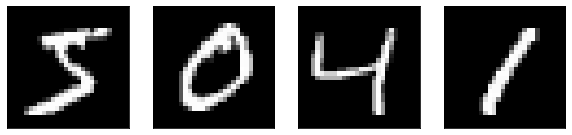

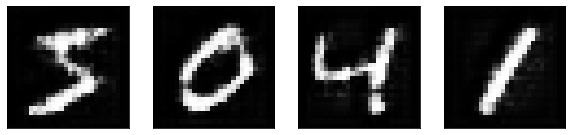

saving...

epoch 20
epoch 20 batch 0 batch total loss 0.12544163
epoch 20 batch 0 batch cluster loss 0.11068691
epoch 20 batch 0 batch regen loss 0.014754709
saving...



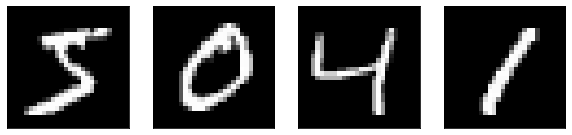

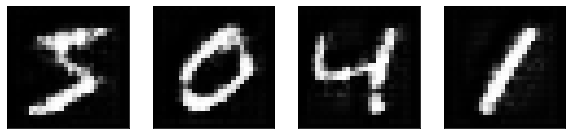

epoch 20 batch 50 batch total loss 0.12516706
epoch 20 batch 50 batch cluster loss 0.1087991
epoch 20 batch 50 batch regen loss 0.016367959
saving...



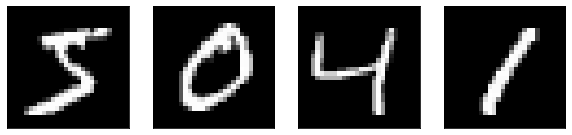

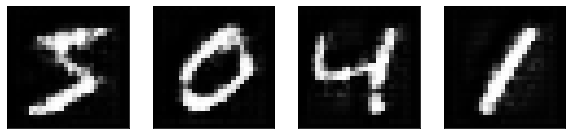

epoch 20 batch 100 batch total loss 0.123097315
epoch 20 batch 100 batch cluster loss 0.10677864
epoch 20 batch 100 batch regen loss 0.016318683
saving...



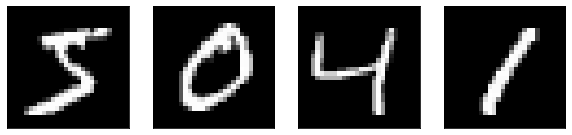

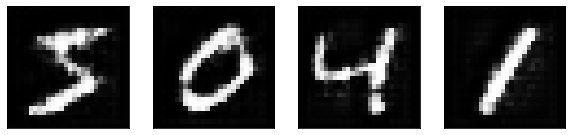


epoch 20 epoch avg loss 0.12635037629723045
epoch 20 epoch avg cluster loss 0.11033414268345272
epoch 20 epoch avg regen loss 0.016016233688757077



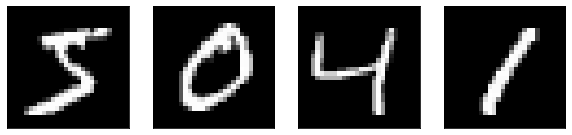

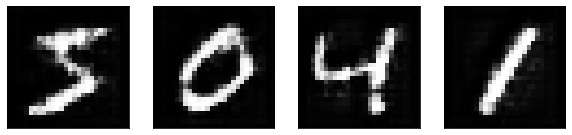

saving...

epoch 21
epoch 21 batch 0 batch total loss 0.13343869
epoch 21 batch 0 batch cluster loss 0.11869707
epoch 21 batch 0 batch regen loss 0.01474162
saving...



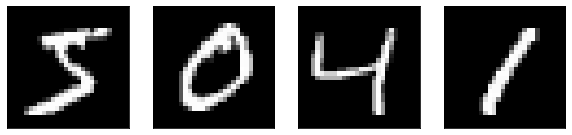

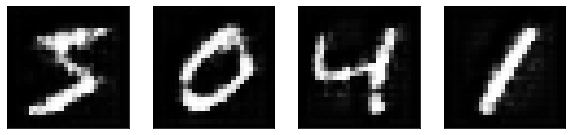

epoch 21 batch 50 batch total loss 0.12999122
epoch 21 batch 50 batch cluster loss 0.11365582
epoch 21 batch 50 batch regen loss 0.016335394
saving...



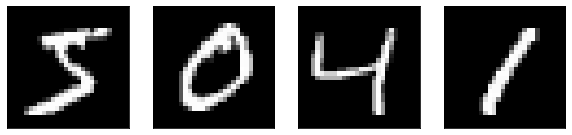

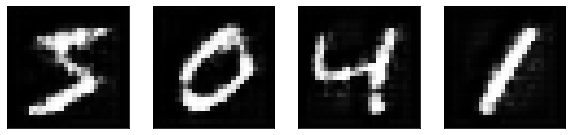

epoch 21 batch 100 batch total loss 0.133524
epoch 21 batch 100 batch cluster loss 0.11723034
epoch 21 batch 100 batch regen loss 0.016293658
saving...



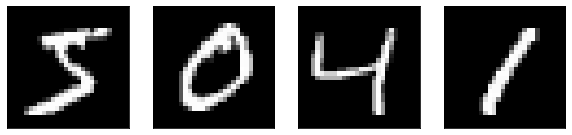

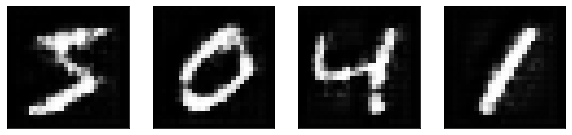


epoch 21 epoch avg loss 0.12622751709136923
epoch 21 epoch avg cluster loss 0.11023301642261825
epoch 21 epoch avg regen loss 0.015994500621395596



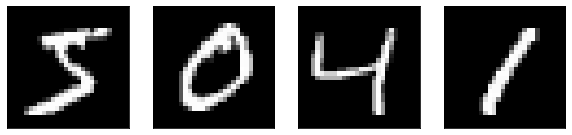

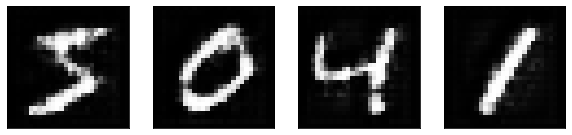

saving...

epoch 22
epoch 22 batch 0 batch total loss 0.13003437
epoch 22 batch 0 batch cluster loss 0.11533847
epoch 22 batch 0 batch regen loss 0.0146959005
saving...



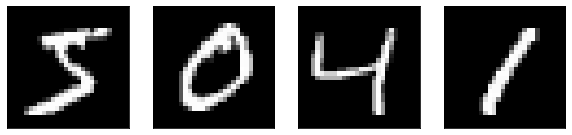

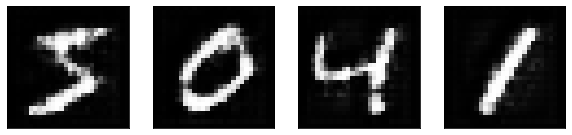

epoch 22 batch 50 batch total loss 0.12419063
epoch 22 batch 50 batch cluster loss 0.107886955
epoch 22 batch 50 batch regen loss 0.016303673
saving...



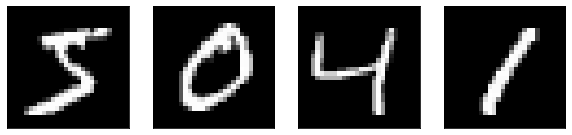

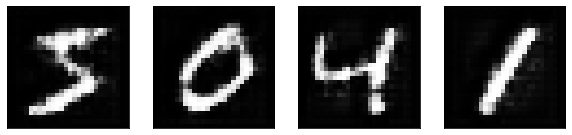

epoch 22 batch 100 batch total loss 0.12334286
epoch 22 batch 100 batch cluster loss 0.10707955
epoch 22 batch 100 batch regen loss 0.016263308
saving...



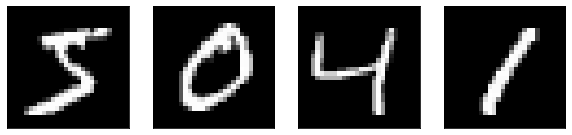

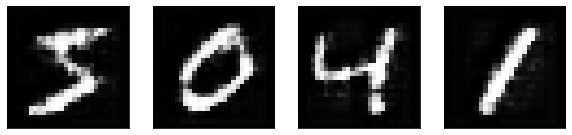


epoch 22 epoch avg loss 0.12664846596071275
epoch 22 epoch avg cluster loss 0.11067793002920383
epoch 22 epoch avg regen loss 0.01597053556845097



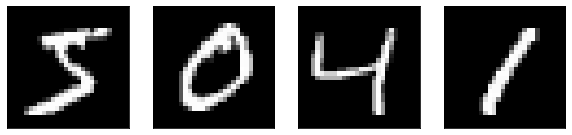

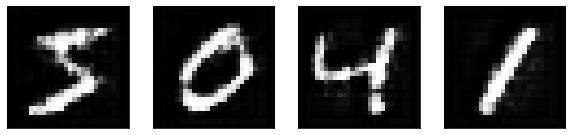

saving...

epoch 23
epoch 23 batch 0 batch total loss 0.12411873
epoch 23 batch 0 batch cluster loss 0.1094381
epoch 23 batch 0 batch regen loss 0.01468063
saving...



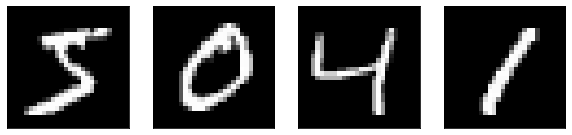

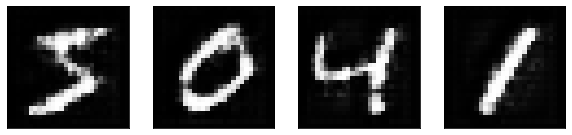

epoch 23 batch 50 batch total loss 0.12005812
epoch 23 batch 50 batch cluster loss 0.10379215
epoch 23 batch 50 batch regen loss 0.016265964
saving...



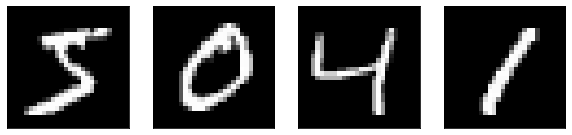

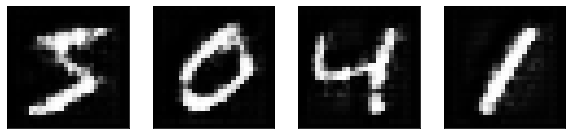

epoch 23 batch 100 batch total loss 0.12794384
epoch 23 batch 100 batch cluster loss 0.11171699
epoch 23 batch 100 batch regen loss 0.016226847
saving...



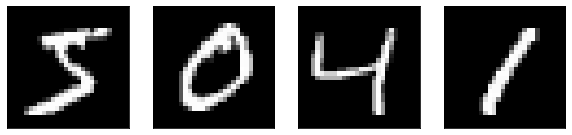

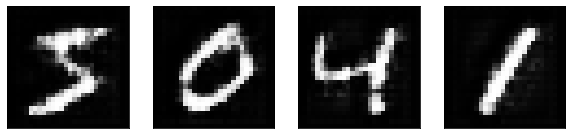


epoch 23 epoch avg loss 0.12594163244179749
epoch 23 epoch avg cluster loss 0.10999665548235683
epoch 23 epoch avg regen loss 0.015944976406961173



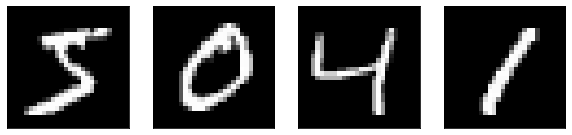

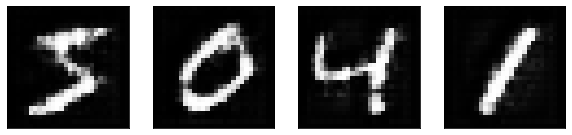

saving...

epoch 24
epoch 24 batch 0 batch total loss 0.13143368
epoch 24 batch 0 batch cluster loss 0.11677263
epoch 24 batch 0 batch regen loss 0.014661048
saving...



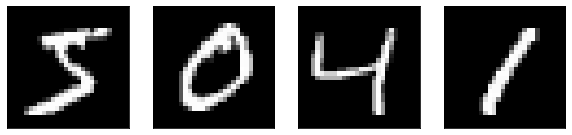

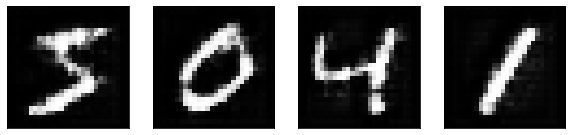

epoch 24 batch 50 batch total loss 0.13895522
epoch 24 batch 50 batch cluster loss 0.12270494
epoch 24 batch 50 batch regen loss 0.01625028
saving...



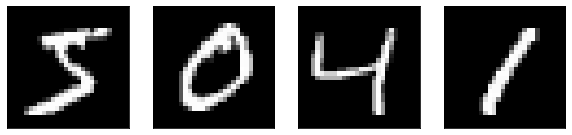

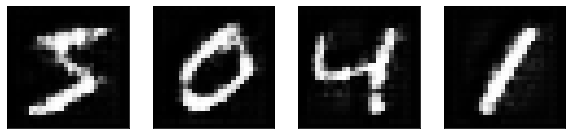

epoch 24 batch 100 batch total loss 0.1240688
epoch 24 batch 100 batch cluster loss 0.107866846
epoch 24 batch 100 batch regen loss 0.016201952
saving...



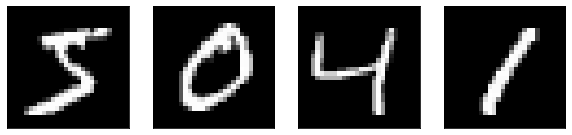

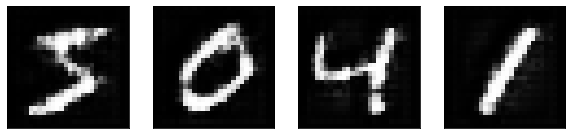


epoch 24 epoch avg loss 0.1262827753799699
epoch 24 epoch avg cluster loss 0.11036455044049327
epoch 24 epoch avg regen loss 0.015918224805303045



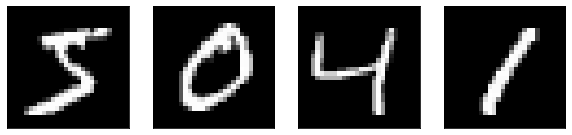

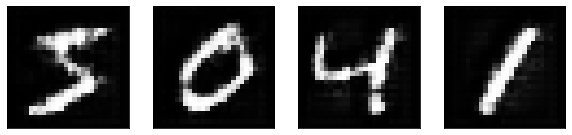

saving...

epoch 25
epoch 25 batch 0 batch total loss 0.13046551
epoch 25 batch 0 batch cluster loss 0.115843624
epoch 25 batch 0 batch regen loss 0.014621876
saving...



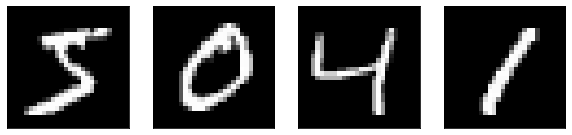

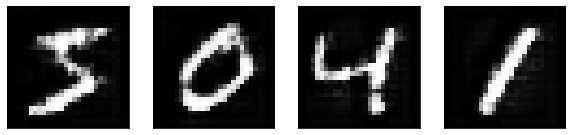

epoch 25 batch 50 batch total loss 0.13060224
epoch 25 batch 50 batch cluster loss 0.114385754
epoch 25 batch 50 batch regen loss 0.016216481
saving...



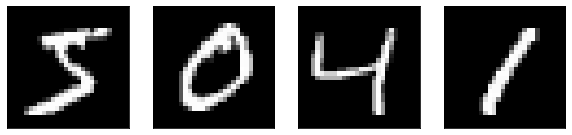

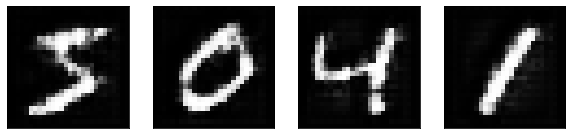

epoch 25 batch 100 batch total loss 0.12633145
epoch 25 batch 100 batch cluster loss 0.11016057
epoch 25 batch 100 batch regen loss 0.016170874
saving...



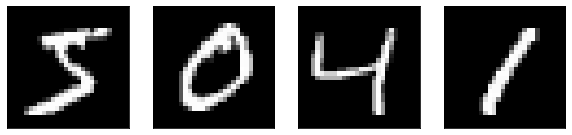

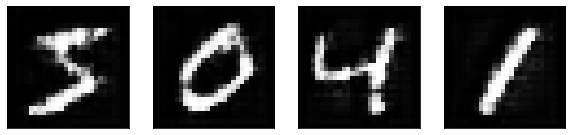


epoch 25 epoch avg loss 0.12578498314813538
epoch 25 epoch avg cluster loss 0.10990160965692189
epoch 25 epoch avg regen loss 0.01588337348332092



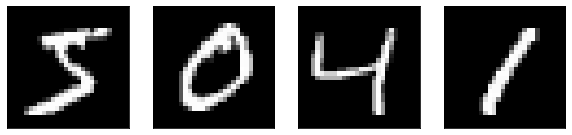

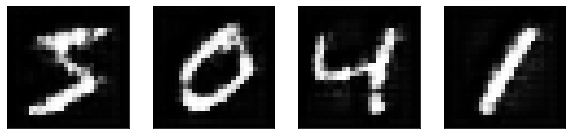

saving...

epoch 26
epoch 26 batch 0 batch total loss 0.12784638
epoch 26 batch 0 batch cluster loss 0.11326432
epoch 26 batch 0 batch regen loss 0.01458205
saving...



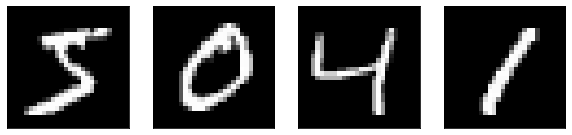

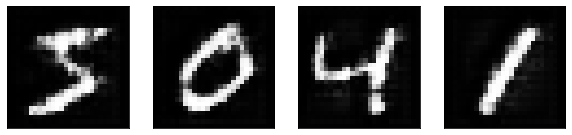

epoch 26 batch 50 batch total loss 0.13599731
epoch 26 batch 50 batch cluster loss 0.11981814
epoch 26 batch 50 batch regen loss 0.016179161
saving...



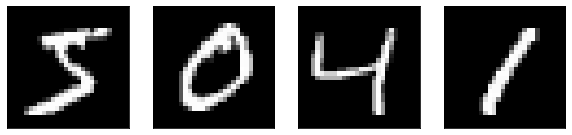

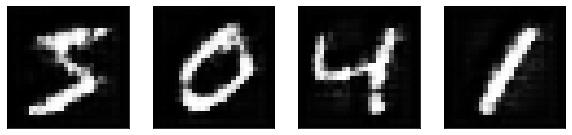

epoch 26 batch 100 batch total loss 0.121916376
epoch 26 batch 100 batch cluster loss 0.10577866
epoch 26 batch 100 batch regen loss 0.016137721
saving...



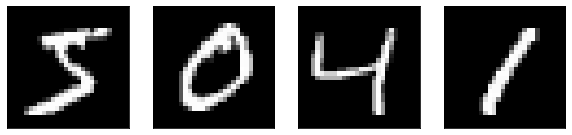

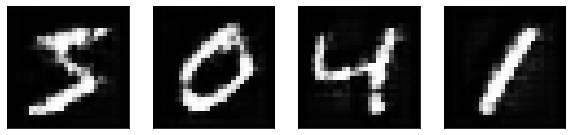


epoch 26 epoch avg loss 0.12540199602875163
epoch 26 epoch avg cluster loss 0.1095443869569986
epoch 26 epoch avg regen loss 0.015857609872848302



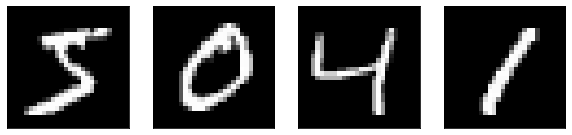

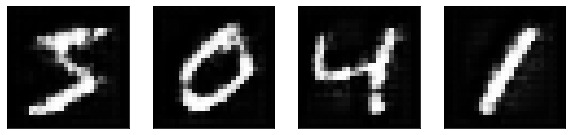

saving...

epoch 27
epoch 27 batch 0 batch total loss 0.12580627
epoch 27 batch 0 batch cluster loss 0.11125831
epoch 27 batch 0 batch regen loss 0.014547956
saving...



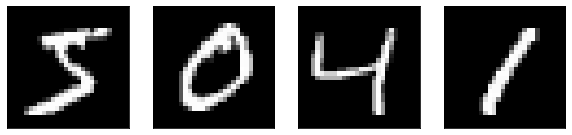

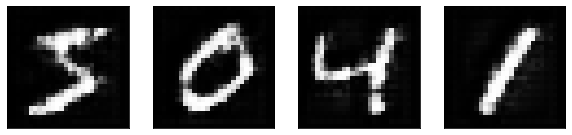

epoch 27 batch 50 batch total loss 0.13283019
epoch 27 batch 50 batch cluster loss 0.11667771
epoch 27 batch 50 batch regen loss 0.016152477
saving...



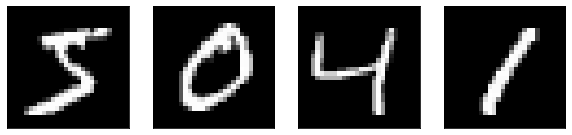

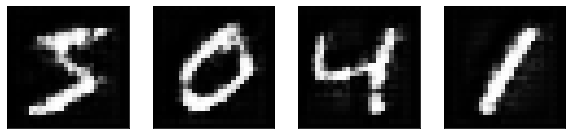

epoch 27 batch 100 batch total loss 0.12712914
epoch 27 batch 100 batch cluster loss 0.11103963
epoch 27 batch 100 batch regen loss 0.016089503
saving...



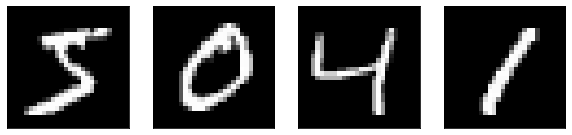

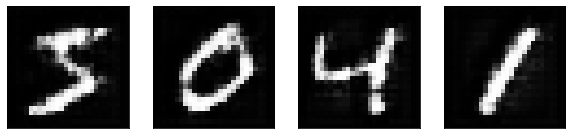


epoch 27 epoch avg loss 0.12558329559988896
epoch 27 epoch avg cluster loss 0.10975092863940271
epoch 27 epoch avg regen loss 0.01583236729789336



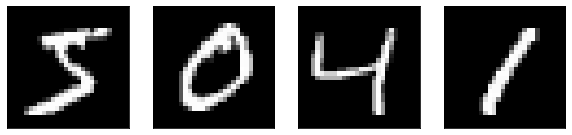

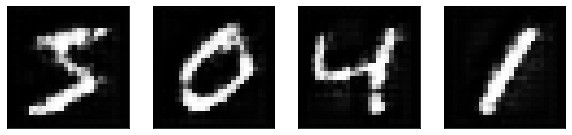

saving...

epoch 28
epoch 28 batch 0 batch total loss 0.12455819
epoch 28 batch 0 batch cluster loss 0.11002806
epoch 28 batch 0 batch regen loss 0.014530128
saving...



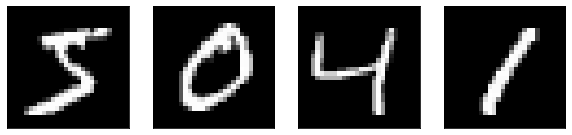

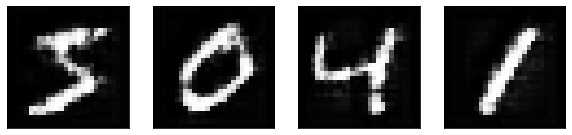

KeyboardInterrupt: 

In [52]:
epoch_avg_total_loss = [0]*total_epochs

epoch_avg_cluster_loss = [0]*total_epochs

epoch_avg_regen_loss = [0]*total_epochs

# total_loss_win = vis.line(
#     Y=np.zeros((1)),
#     X=np.zeros((1)),
#     opts=dict(xlabel='epoch',title='Pre Regen MS LSTM',ylabel='Total Loss',legend=['Loss']))

# cluster_loss_win = vis.line(
#     Y=np.zeros((1)),
#     X=np.zeros((1)),
#     opts=dict(xlabel='epoch',title='Pre Regen MS LSTM',ylabel='CLuster Loss',legend=['Loss']))

# regen_loss_win = vis.line(
#     Y=np.zeros((1)),
#     X=np.zeros((1)),
#     opts=dict(xlabel='epoch',title='Pre Regen MS LSTM',ylabel='Regen Loss',legend=['Loss']))

for epoch in range(total_epochs):
  
    print('epoch', epoch)
  
    avg_total_loss = 0
    avg_cluster_loss = 0
    avg_regen_loss = 0
    total_batches = 0
    
    for batch_idx, (x, target) in enumerate(train_loader):
        
        x, target = x.cuda(), target.numpy()

        x_, z = model(x)
        
        trajects = ms_clust(z.t())
        
        path_z = path_embed(trajects)
        
        total_loss, cluster_loss, regen_loss = ms_ae_loss(x, x_, path_z, target)
    
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
        avg_total_loss += total_loss.cpu().detach().numpy()
        avg_cluster_loss += cluster_loss.cpu().detach().numpy()
        avg_regen_loss += regen_loss.cpu().detach().numpy()
    
        if batch_idx % 50 == 0:
            print('epoch', epoch, 'batch', batch_idx, 'batch total loss', total_loss.cpu().detach().numpy())
            print('epoch', epoch, 'batch', batch_idx, 'batch cluster loss', cluster_loss.cpu().detach().numpy())
            print('epoch', epoch, 'batch', batch_idx, 'batch regen loss', regen_loss.cpu().detach().numpy())
            print('saving...')
            torch.save(model.state_dict(), '/home/ankitas/btp_mean_shift/save/'+sname+'.pt')
            print()
            plot_regen(model)
    
        total_batches += 1
   
    epoch_avg_total_loss[epoch] = avg_total_loss/total_batches
    epoch_avg_cluster_loss[epoch] = avg_cluster_loss/total_batches
    epoch_avg_regen_loss[epoch] = avg_regen_loss/total_batches
  
    loss_file = open('/home/ankitas/btp_mean_shift/save/loss_list_'+sname+'.pkl', 'wb+')
    pickle.dump([epoch_avg_total_loss, epoch_avg_cluster_loss, epoch_avg_regen_loss], loss_file)
#     pickle.dump(epoch_avg_total_loss, loss_file)
    loss_file.close()
  
    print()
    print('epoch', epoch, 'epoch avg loss', epoch_avg_total_loss[epoch])
    print('epoch', epoch, 'epoch avg cluster loss', epoch_avg_cluster_loss[epoch])
    print('epoch', epoch, 'epoch avg regen loss', epoch_avg_regen_loss[epoch])
    print()

#     vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_total_loss[epoch]]),win=total_loss_win,update='append')
#     vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_cluster_loss[epoch]]),win=cluster_loss_win,update='append')
#     vis.line(X=np.ones(1)*(epoch+1),Y=np.array([epoch_avg_regen_loss[epoch]]),win=regen_loss_win,update='append')
    plot_regen(model)
    print('saving...')
    torch.save(model.state_dict(), '/home/ankitas/btp_mean_shift/save/'+sname+'.pt')
    print()
 
  